# Intro to LangChain and watsonx.ai Python SDK

Welcome to the Lab 5. 

In the previous labs, we explored Prompt Lab and also the challenges of prompt engineering; learning how to tweak our wording, choose different models, and optimize model parameters. We saw that minor changes can significantly enhance the results generated by language models.

In this lab, we will apply our new knowledge to a real-world use case as we continue learning about best practices related to prompt coding. Using the [watsonx.ai Python SDK](https://ibm.github.io/watsonx-ai-python-sdk/) to programmatically interact with watsonx.ai, we will use prompt templating techniques provided by the [LangChain Python library](https://python.langchain.com/) to streamline our interactions with the language model and maximize its potential.

The concept of Prompt Templates provided by LangChain allows you to construct prompt templates that can be easily filled with specific information to generate a wide range of outputs that you can provide to watsonx.ai. You can even leverage prompt templates specific to few-shot prompting, as you will see below.

## Recreating Prompt Builder Prompts Using LangChain Prompt Patterns

### Scenario: Personalized Recommendation for XYZ Retail Company <a id="step3"></a>

XYZ Retail is a popular online retail store that sells a wide range of products, including electronics, clothing, home goods, and more. They have a large customer base and want to provide a personalized shopping experience to enhance customer satisfaction and boost sales.

To achieve that goal, XYZ wants to leverage generative AI to create fact sheets about each of their customers. These fact sheets will summarize relevant information such as customer demographics (name, age, location), and purchase history. These fact sheets will help XYZ Retail's sales team build stronger customer relationships, increase customer satisfaction and drive repeat purchases.


You start by performing prompt engineering in Prompt Lab, and you might test base model output with an initial prompt like this:

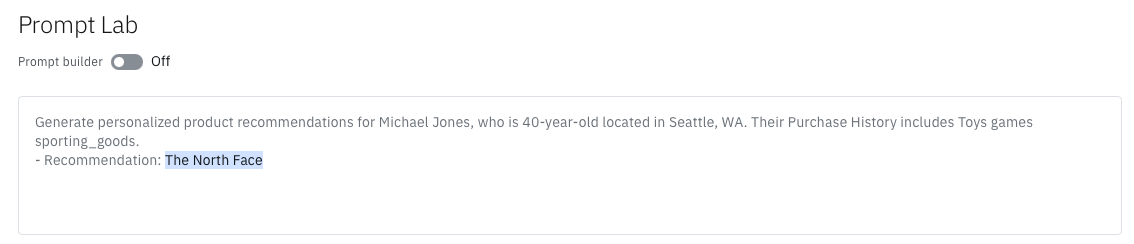

The model's recommendation is not accurate or useful as the customer Michael Jones had bought toys and games not outdoor activewear. Fortunately you learned in the Prompt Engineering lab that Few Shot Learning can help you obtain better results. 

What happens when we provide a few examples using Prompt Builder to guide the LLM into generating more meaningful recommendations. 

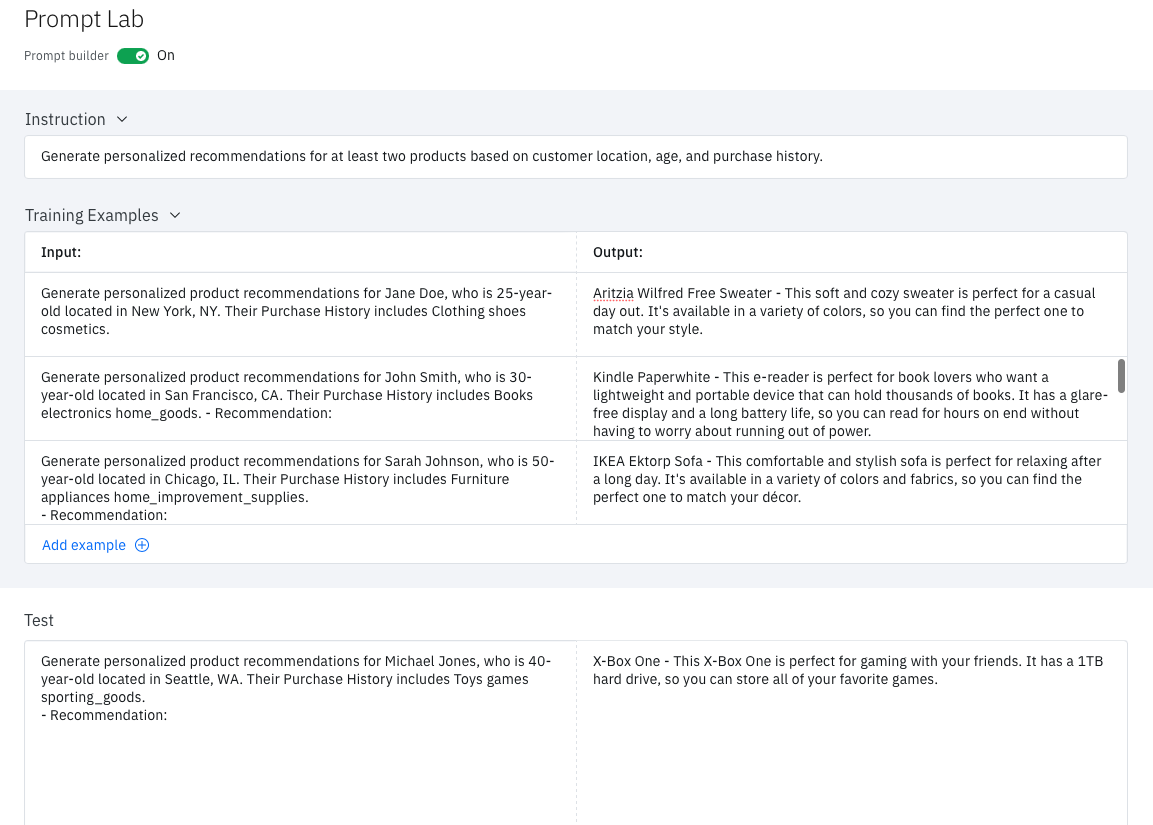

Great, the product recommendation for Michael Jones is much better.  However how do you productionize your few shot prompting to generate recommendations for all of XYZ Retail customers? Copy and pasting each customer's info into Prompt Builder would take too long.  

You'll need a programmatic solution.  Maybe you could even generate a large set of examples then use that for Tuning a model in watsonx.ai.  But we're getting ahead of ourselves as you'll learn about building a Prompt Tuning dataset in a later lab.

## 1. Load the required libraries  <a id="step1"></a>

In [3]:
%pip install wget | tail -n 1


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import wget
import pandas as pd
from langchain import PromptTemplate, FewShotPromptTemplate
from ibm_watsonx_ai.foundation_models import Model
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

## 2. Create a Factsheet for each customer using Prompt Patterns  <a id="step2"></a>

### **2.1 What is a Prompt Template?**

The [PromptTemplate class](https://python.langchain.com/docs/modules/model_io/prompts/prompt_templates/) in the [LangChain Python library](https://python.langchain.com/docs/get_started/introduction) provides a flexible approach to creating prompts from structured templates.  We will use the PromptTemplate class to simplify creation of our few shot prompts for XYZ Retail.

XYZ Retail has provided you their customer's data in .csv format. To generate prompts for each customer, you will need to transform the prompt that you engineered in Prompt Builder into a more useful programmatic format. Using the PromptTemplate class, you can easily substitute customer data to generate one or multiple prompts.

The PromptTemplate class defines a schema where variables to replace are placed inside curly braces "{}". In Python parlance, it's simply using "f-strings" under the hood. These curly braces serve as a placeholder for the actual data that will be substituted into the template.

Let's see how this works in practice.

### **2.2 Creating a simple prompt from a template**

A prompt template can be created using the PromptTemplate class from a string or .txt file. There are [additional PromptTemplate examples](https://api.python.langchain.com/en/latest/prompts/langchain.prompts.prompt.PromptTemplate.html#langchain.prompts.prompt.PromptTemplate) provided in the LangChain documentation.

#### 2.2.1 Prompt Template From String

In [2]:
# template is a string with variable names in curly brackets
pattern = "input: {name} {family_name} is {age} and lives in {location}. They bought {purchase_history}"

# generate template
prompt_template = PromptTemplate.from_template(pattern)
prompt_template.template

'input: {name} {family_name} is {age} and lives in {location}. They bought {purchase_history}'

In [3]:
# now let's provide some values and generate our prompt
# notice how the variables coincide with those we specified in curly brackets
prompt = prompt_template.format(name="Jane", 
                                family_name="Doe",
                                age=43,
                                location="San Francisco, CA",
                                purchase_history = "groceries, household goods and travel supplies")

prompt

'input: Jane Doe is 43 and lives in San Francisco, CA. They bought groceries, household goods and travel supplies'

#### 2.2.2 Prompt Template From File
Prompt patterns can also be stored as a txt file:

In [4]:
# Download the data

filename = 'customer_factsheet_lang.txt'
base_url = 'https://raw.githubusercontent.com/muqbilk/watsonx-SPE-Lab/refs/heads/main/self-guided-labs/lab-5-langchain-intro/templates/'

if not os.path.isfile(filename): wget.download(base_url + filename)

# We create a template from a file:
_path_to_file = "customer_factsheet_lang.txt"

# this time we provide the file that has our variables as its columns 
example_prompt = PromptTemplate.from_file(_path_to_file)

print(example_prompt.template)

input: {name} {family_name} is {age} years old and lives in {city}, {state}. Their purchase history includes {purchase_history}.
output: Recommendations: Item 1: {recommendation_1} Item 2: {recommendation_2}



Just like in 2.1, we can populate this teamplate from a dictionary containing the values of the input variables. Looping over three examples:

In [5]:
# we can iterate through a list to populate the template

examples = [
    {
        "name":"Jane", 
        "family_name":"Doe", 
        "age":43, 
        "city":"San Francisco", 
        "state":"CA",
        "purchase_history":"groceries, household goods and travel supplies", 
        "recommendation_1":"Basket of organic fruits",
        "recommendation_2":"Lightweight carry-on suitcase"
    },{
        "name":"Siamak", 
        "family_name":"Baharoo", 
        "age":57, 
        "city":"Chicago", 
        "state":"IL",
        "purchase_history":"Books electronics home_goods", 
        "recommendation_1":"Kindle Paperwhite - This e-reader is perfect for book lovers who want a lightweight and portable device that can hold thousands of books. It has a glare-free display and a long battery life, so you can read for hours on end without having to worry about running out of power.",
        "recommendation_2":"Google Home Mini - This smart speaker is perfect for controlling your home's smart devices with your voice. You can use it to play music, set alarms, get news, and more. It's also a great way to stay connected with friends and family."
    },{
        "name":"Luis", 
        "family_name":"Cooli", 
        "age":21, 
        "city":"New York City", 
        "state":"NY",
        "purchase_history":"Clothing shoes cosmetics", 
        "recommendation_1":"Aritzia Wilfred Free Sweater - This soft and cozy sweater is perfect for a casual day out. It's available in a variety of colors, so you can find the perfect one to match your style.",
        "recommendation_2":"Steve Madden Pointed Toe Pumps - These stylish pumps are perfect for a night out on the town. They're comfortable and versatile, so you can wear them with a variety of outfits."
    }
]

for example in examples: 
    print(example_prompt.format(**example))

input: Jane Doe is 43 years old and lives in San Francisco, CA. Their purchase history includes groceries, household goods and travel supplies.
output: Recommendations: Item 1: Basket of organic fruits Item 2: Lightweight carry-on suitcase

input: Siamak Baharoo is 57 years old and lives in Chicago, IL. Their purchase history includes Books electronics home_goods.
output: Recommendations: Item 1: Kindle Paperwhite - This e-reader is perfect for book lovers who want a lightweight and portable device that can hold thousands of books. It has a glare-free display and a long battery life, so you can read for hours on end without having to worry about running out of power. Item 2: Google Home Mini - This smart speaker is perfect for controlling your home's smart devices with your voice. You can use it to play music, set alarms, get news, and more. It's also a great way to stay connected with friends and family.

input: Luis Cooli is 21 years old and lives in New York City, NY. Their purchase

## 3. Create Prompt Examples based on Customers Factsheet <a id="step3"></a>
The value of PromptTemplate arises when generating a large number of prompts either as examples for bulk evaluation of an engineered prompt or for creation of a Tuning dataset

### 3.1 Create a few shot prompt
We will start by creating a FewShotPromptTemplate object. This class allows to create a prompt made of few repetitions of a PromptTemplate. Details can be found in the [FewShotPromptTemplate class documentation](https://python.langchain.com/docs/modules/model_io/prompts/prompt_templates/few_shot_examples)

In [6]:
# Next step create a few shot prompt template

few_shot_examples = examples[:2]
few_shot_input = examples[2].copy()
del few_shot_input['recommendation_1']
del few_shot_input['recommendation_2']

def make_few_shot_prompt(few_shot_examples, few_shot_input):
    """
    Generate a few-shot prompt using the FewShotPromptTemplate class.

    Parameters:
    - few_shot_examples: List of examples to be shown as few-shot examples.
    - few_shot_input: Input for which the prompt will be generated.

    Returns:
    - A string representing the formatted few-shot prompt.
    """
    prompt = FewShotPromptTemplate(
        examples=few_shot_examples, 
        example_prompt=example_prompt, 
        suffix='input: "{name} {family_name} is {age} years old and lives in {city}, {state}. Their purchase history includes {purchase_history}."\noutput: ', 
        input_variables=["name", "family_name", "age", "city","state", "purchase_history"]
    )
    # Return the formatted prompt using the provided input data
    return prompt.format(**few_shot_input)


few_shot_prompt = make_few_shot_prompt(few_shot_examples, few_shot_input)
print(few_shot_prompt)

input: Jane Doe is 43 years old and lives in San Francisco, CA. Their purchase history includes groceries, household goods and travel supplies.
output: Recommendations: Item 1: Basket of organic fruits Item 2: Lightweight carry-on suitcase


input: Siamak Baharoo is 57 years old and lives in Chicago, IL. Their purchase history includes Books electronics home_goods.
output: Recommendations: Item 1: Kindle Paperwhite - This e-reader is perfect for book lovers who want a lightweight and portable device that can hold thousands of books. It has a glare-free display and a long battery life, so you can read for hours on end without having to worry about running out of power. Item 2: Google Home Mini - This smart speaker is perfect for controlling your home's smart devices with your voice. You can use it to play music, set alarms, get news, and more. It's also a great way to stay connected with friends and family.


input: "Luis Cooli is 21 years old and lives in New York City, NY. Their purch

### 3.2 Bulk Creation of Prompts
Using the FewShotPromptTemplate class, we can now create a function that generates a list a few shot prompts populating them iteratively from values directy extracted from a notebook.

We can choose how many single prompts are include in one few shot prompt. The output of the function is a list of few shot prompts. 

In [7]:
#Download the data
filename = 'customer_factsheet.csv'
base_url = 'https://raw.githubusercontent.com/muqbilk/watsonx-SPE-Lab/refs/heads/main/self-guided-labs/lab-5-langchain-intro/data/'

if not os.path.isfile(filename): wget.download(base_url + filename)

# Specify the path to the CSV file containing the data
csv_file_path = "customer_factsheet.csv"

def sub_all_from_csv(csv_file_path, n_prompt_examples=2):
    """
    Generates a list of few-shot prompts using the FewShotPromptTemplate class. 
    The prompts are populated iteratively from values extracted from a CSV file.

    Parameters:
    - csv_file_path: The path to the CSV file.
    - n_prompt_examples: The number of examples included in one few-shot prompt.

    Returns:
    - list_of_prompts: A list of few-shot prompts.
    """

    df = pd.read_csv(csv_file_path)
    examples = [example for _, example in df.transpose().to_dict().items()]

    i=0
    list_of_prompts = []

    while i < len(df):
        few_shot_examples = examples[i:i+n_prompt_examples]
        few_shot_input = examples[i+n_prompt_examples].copy()
        del few_shot_input['recommendation_1']
        del few_shot_input['recommendation_2']

        list_of_prompts.append(make_few_shot_prompt(few_shot_examples, few_shot_input))
        
        i = i+n_prompt_examples +1

    # Return the list of few-shot prompts
    return list_of_prompts

In [8]:
list_of_prompts = sub_all_from_csv(csv_file_path)
print(list_of_prompts[0])

input: John Smith is 30 years old and lives in San Francisco, CA. Their purchase history includes Books electronics home_goods.
output: Recommendations: Item 1: Kindle Paperwhite - This e-reader is perfect for book lovers who want a lightweight and portable device that can hold thousands of books. It has a glare-free display and a long battery life, so you can read for hours on end without having to worry about running out of power. Item 2: Google Home Mini - This smart speaker is perfect for controlling your home's smart devices with your voice. You can use it to play music, set alarms, get news, and more. It's also a great way to stay connected with friends and family.


input: Jane Doe is 25 years old and lives in New York, NY. Their purchase history includes Clothing shoes cosmetics.
output: Recommendations: Item 1: Aritzia Wilfred Free Sweater - This soft and cozy sweater is perfect for a casual day out. It's available in a variety of colors, so you can find the perfect one to mat

### 3.2 Additional Examples
You can explore [additional examples using the PromptTemplate](https://api.python.langchain.com/en/latest/prompts/langchain.prompts.prompt.PromptTemplate.html#langchain.prompts.prompt.PromptTemplate)

## 4. Prompt evaluation and few shot learning from bulk created prompts <a id="step4"></a>
In the prior examples, you created a "2-shot learning" prompt.  I.e. there were three inputs but only two complete outputs.  By using a larger dataset this way, you can perform bulk testing of your prompt.

E.g. two of your data sample are used to train while the "output" of the 3rd can be compared against the model output to ensure your prompt is performing as expected.  You can now execute these few shot prompts to see how well our engineered prompt works across numerous examples

### 4.1 Import Watsonx.ai access credentials and load model
Make sure you copied the .env file that you created earlier into the same directory as this notebook

In [ ]:
api_key = "ENTER_APIKEY_HERE"
project_id = "ENTER_PROJECT_ID_HERE"
ibm_cloud_url = "https://us-south.ml.cloud.ibm.com"

if api_key is None or ibm_cloud_url is None or project_id is None:
    print("Ensure you copied the .env file that you created earlier into the same directory as this notebook")
else:
    creds = {
        "url": ibm_cloud_url,
        "apikey": api_key 
    }


model_params = {
    GenParams.DECODING_METHOD: "greedy",
    GenParams.MIN_NEW_TOKENS: 50,
    GenParams.MAX_NEW_TOKENS: 100
}

# Instantiate a model proxy object to send your requests
model = Model(
    model_id='google/flan-ul2',
    params=model_params,
    credentials=creds,
    project_id=project_id)

### 4.2 Send prompts to Watsonx.ai

In [12]:
responses = [model.generate_text(prompt) for prompt in list_of_prompts]
for i, response in enumerate(responses):
    lines = str(list_of_prompts[i]).strip().split("\n")
    user_description = str(lines[8])
    print(f"\n{user_description}")
    print(f"\noutput: {response}")
    print("---------------------")


input: "Michael Jones is 40 years old and lives in Seattle, WA. Their purchase history includes Toys games sporting_goods."

output: Recommendations: Item 1: RC Helicopter - This RC helicopter is great for kids and adults alike. It can fly up to a distance of 30 feet and has a gyroscope for added stability. Item 2: RC Helicopter - This RC helicopter is great for kids and adults alike. It can fly up to a distance of 30 feet and has a gyroscope for added
---------------------

input: "Ashley Brown is 20 years old and lives in Los Angeles, CA. Their purchase history includes Makeup skincare fashion."

output: Recommendations: Item 1: Makeup: Ashley Brown likes makeup. Item 2: Skincare: Ashley Brown likes skincare. Item 3: Fashion: Ashley Brown likes fashion. Item 4: Ashley Brown is 20 years old. Item 5: Ashley Brown lives in Los Angeles, CA.
---------------------

input: "Emily Johnson is 55 years old and lives in Dallas, TX. Their purchase history includes Furniture appliances home_impr

### Few shot prompt analysis
These results are not bad.  Electronics for a customer with a history of buying toys and games.  Likewise cosmetics and furniture for the other two customers accurately reflects their purchase history.  

In some cases, the model adds more recommendations instead of providing a detailed description of the product.  These additional items are not as accurate as there was no training data for additional items.  

It would likely also help to add an instruction in the beginning so that can be an exercise for you to attempt.

## 5. Congratulations
Congratulations on completing the lab and exploring the fascinating world of bulk creation of Few Shot Prompts using PromptTemplate! 

Through the practical use case of generating personalized product recommendations, you have witnessed the power of tailoring prompts to individual customer profiles. By incorporating customer-specific details and programmatically generating bulk examples, you can fine-tune the model for your specific use case, resulting in more accurate and tailored outputs. 

Continuously iterating and refining your prompts based on these examples will unlock the full potential of language models and enhance their performance across various domains. Keep experimenting and leveraging prompt engineering techniques to optimize your interactions with language models and drive impactful results in your projects.